In [0]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
google = pd.read_csv('gdrive/My Drive/CoderSchool-FTMLE/week_3/assignments/data/02-google-play-store/google-play-store.csv')

##Clean Data


####Drop rows with wrong values

In [0]:
google.drop(10472,inplace = True)

####Pre processing price

In [0]:
def pre_processing_price(price):
    s = re.sub(r'[^0-9.]','',price)
    if len(s)==0:
        s = 0
    return round(float(s),2)

In [0]:
google["Price"] = google["Price"].apply(pre_processing_price)

####Pre processing installs

In [0]:
def pre_processing_installs(install):
    s = re.sub(r'[^0-9]','',install)
    if len(s)==0:
        s = 0
    return int(s)

In [0]:
google["Clean Installs"] = google["Installs"].apply(pre_processing_installs)

####Pre processing size

In [0]:
google['Clean Size'] = google['Size'].map(lambda x: x.rstrip('M'))
google['Clean Size'] = google['Clean Size'].map(lambda x: str(round((float(x.rstrip('k'))/1024), 1)) if x[-1]=='k' else x)
google['Clean Size'] = google['Clean Size'].map(lambda x: np.nan if x.startswith('Varies') else x)

In [0]:
google['Clean Size'] = google['Clean Size'].astype(float)

####Create new revenue column:
>* If paid app: revenue = installation * price
* If free app: revenue = installation * 0.02 ( $ 0.02 per install according to Forbes) 

In [0]:
def create_revenue(df):
    df["Revenue"] = np.nan
    for i in range(df.shape[0]):
        if df.loc[i,"Type"] == "Free":
            df.loc[i,"Revenue"]=df.loc[i,"Clean Installs"]* 0.02
        else:
            df.loc[i,"Revenue"]=df.loc[i,"Clean Installs"]* df.loc[i,"Price"]

In [0]:
create_revenue(google)

KeyError: ignored

####Split data into two type: free vs paid app

In [0]:
free_app = google[google["Type"]=="Free"]
paid_app = google[google["Type"]=="Paid"]

##Data analysis

###Compare FREE apps and PAID apps 

####Compare the number of apps created and revenue generated by different types of app




In [0]:
apps = google.groupby("Type").App.count()
revenues = google.groupby("Type").Revenue.sum()
free_paid = pd.concat([apps,revenues],axis=1)
free_paid["Revenue per App"] = free_paid["Revenue"]/free_paid["App"]
free_paid

App       Revenue  Revenue per App
Type                                      
Free  10039  3.340246e+09    332726.998960
Paid    800  3.858479e+08    482309.833812

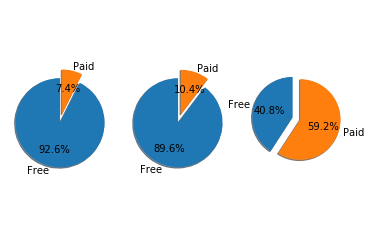

In [0]:
fig, ax = plt.subplots(1, 3)
explode=(0,0.2)
ax[0].pie(apps.values, explode=explode, labels=apps.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].axis('equal')
ax[1].pie(revenues.values, explode=explode, labels=revenues.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')
ax[2].pie(free_paid["Revenue per App"], explode=explode, labels=free_paid.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[2].axis('equal')
fig.show()
fig.to_file

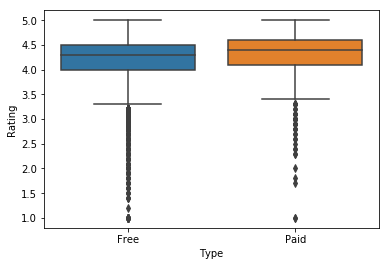

In [0]:
sns.boxplot(x=google["Type"],y= google["Rating"])

**Looking at the pie chart first, it is clear that the free apps dominate the app market. More than 90% of app on google play store is free. Based on the human natural instinct, people would prefer free stuff than paid stuff. Therefore, the total installation of free apps outweigh paid apps, leading to higher total revenue. On the other hand, the revenue per paid app is % higher than free app. Beside the revenue, the average rate of rating in paid app is at a great height. If you dig deeper into the boxplot above, what stands out is that free apps have much more outliers than paid apps. This means that lots of free apps are not well built. In breif, based on the above observation, when it comes to decide which types of app to develope. You must think of 2 aspects. Do you want your app to be used in a large size of people or you want to make the most out of it. If you want to attract as much users as possible then free apps is your answer. Build free app thi luong khach hang cua minh nham toi se da dang hon va khong bi han che. However, if you want to earn high revenue, then you should go with paid app. But in both case, remember that app market is larger and diverse so you must put enough effort in creating the app. Otherwise, you can't attract customers. even if your app is free.**

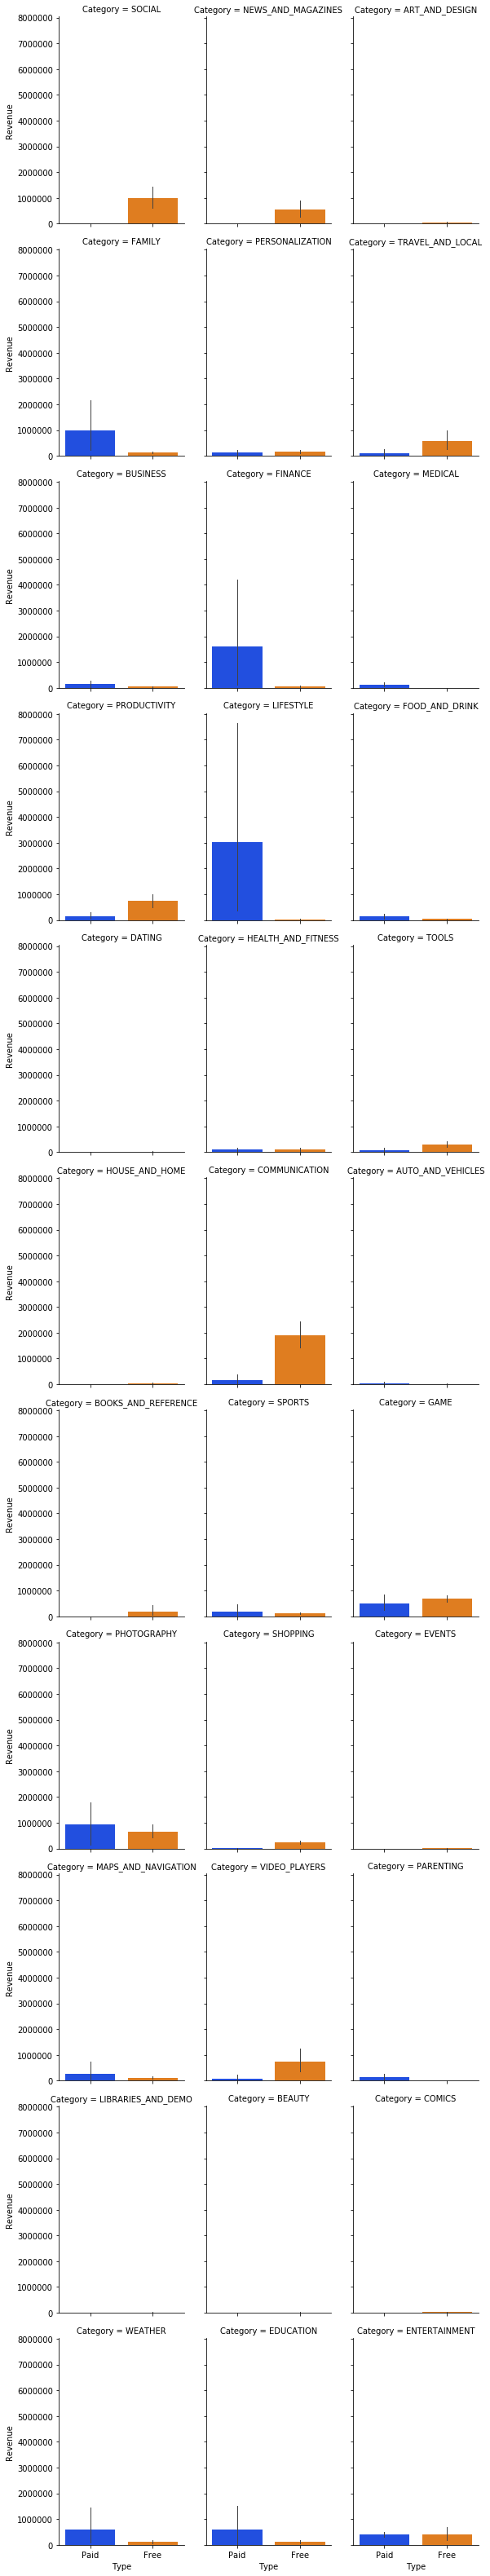

In [0]:
sns.catplot(x="Type", y="Revenue",col="Category",
                 data=google.sort_values(by="Revenue"), kind="bar",col_wrap=3,
                 height=4, aspect=.7,errwidth=1,palette="bright")

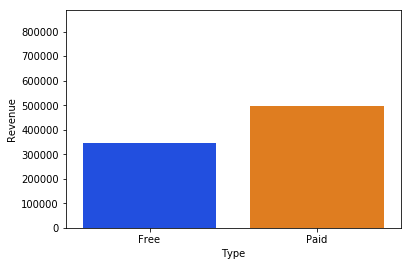

In [0]:
sns.barplot(x=google["Type"],y= google["Revenue"], errwidth=0,palette="bright")

###Free app

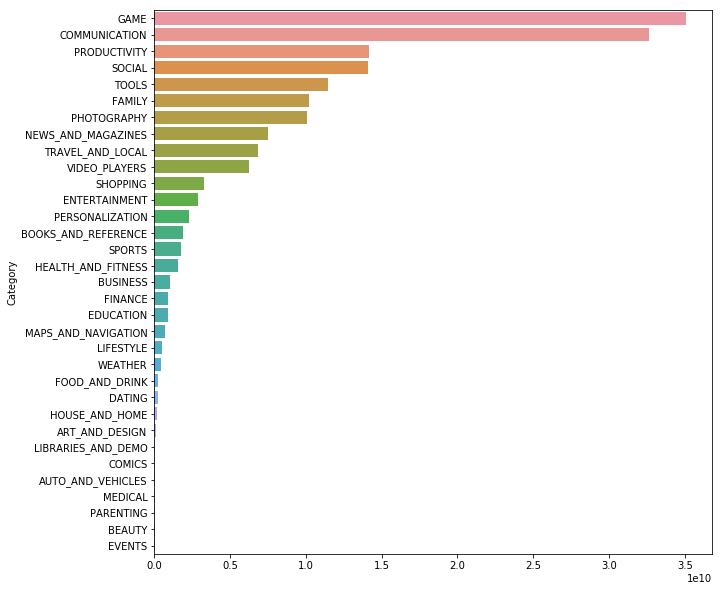

In [0]:
fa_mean_install = free_app.groupby("Category").sum()["Clean Installs"].sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(fa_mean_install.values,fa_mean_install.index)
plt.show()

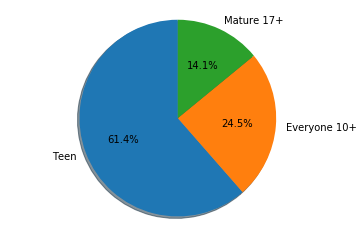

In [0]:
content_rating = free_app[(free_app["Category"]=="GAME") & (free_app["Content Rating"]!="Everyone")]["Content Rating"].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(content_rating.values, labels=content_rating.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

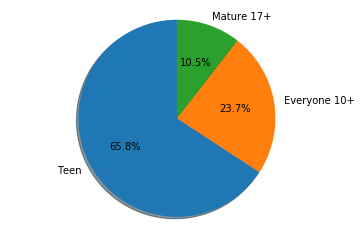

In [0]:
content_rating = paid_app[(paid_app["Category"]=="GAME") & (paid_app["Content Rating"]!="Everyone")]["Content Rating"].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(content_rating.values, labels=content_rating.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

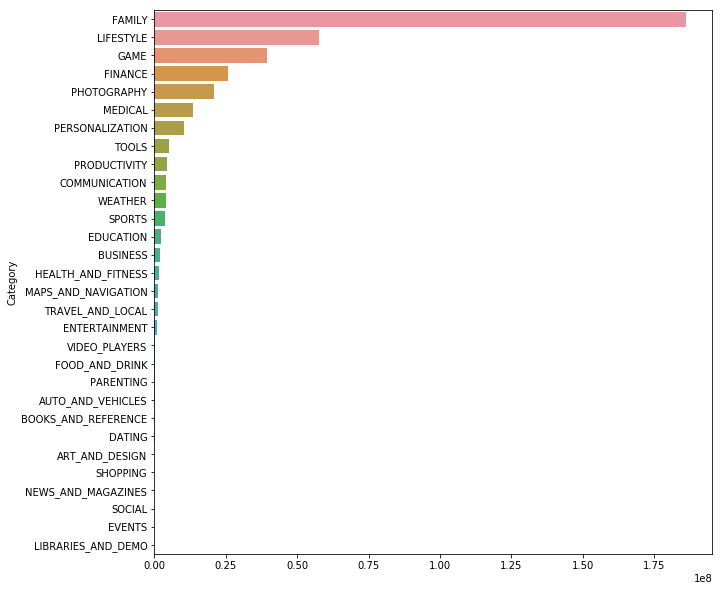

In [0]:
pa_mean_install = paid_app.groupby("Category").sum()["Revenue"].sort_values(ascending = False)
plt.figure(figsize=(10,10))
sns.barplot(pa_mean_install.values,pa_mean_install.index)
plt.show()

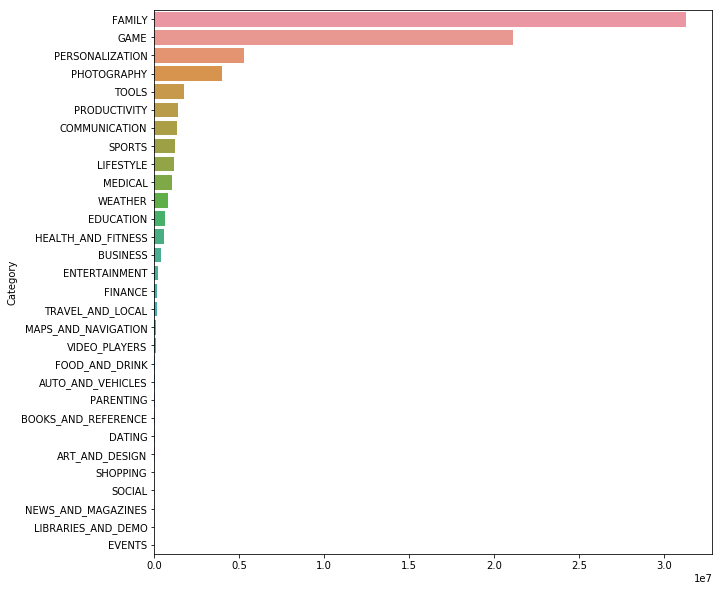

In [0]:
pa_mean_install = paid_app.groupby("Category").sum()["Clean Installs"].sort_values(ascending = False)
plt.figure(figsize=(10,10))
sns.barplot(pa_mean_install.values,pa_mean_install.index)
plt.show()

In [0]:
paid_app[(paid_app["Category"]=="FAMILY")].sort_values(by="Clean Installs",ascending=False).head()

App Category  ...  Clean Size     Revenue
4347             Minecraft   FAMILY  ...         NaN  69900000.0
2241             Minecraft   FAMILY  ...         NaN  69900000.0
9678     Where's My Water?   FAMILY  ...        69.0   1990000.0
6675  Infinity Dungeon VIP   FAMILY  ...        44.0    990000.0
4260     Cut the Rope GOLD   FAMILY  ...        43.0    990000.0

[5 rows x 16 columns]

In [0]:
paid_app[(paid_app["Category"]=="FAMILY")].sort_values(by="Revenue",ascending=False).head()

App Category  ...  Clean Installs     Revenue
4347                   Minecraft   FAMILY  ...        10000000  69900000.0
2241                   Minecraft   FAMILY  ...        10000000  69900000.0
5354              I am Rich Plus   FAMILY  ...           10000   3999900.0
5366                   I Am Rich   FAMILY  ...           10000   3899900.0
2242  Card Wars - Adventure Time   FAMILY  ...         1000000   2990000.0

[5 rows x 15 columns]

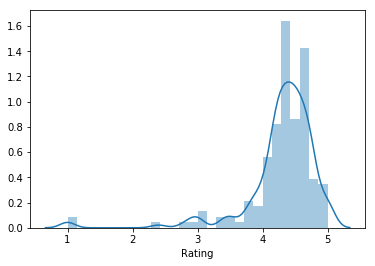

In [0]:
sns.distplot(paid_app[(paid_app["Category"]=="FAMILY")&(~paid_app["Rating"].isnull())]["Rating"])

In [0]:
number_of_app=paid_app.groupby("Category").App.count()
installation = paid_app.groupby("Category").sum()["Clean Installs"]
app_install = pd.concat([number_of_app, installation], axis=1)

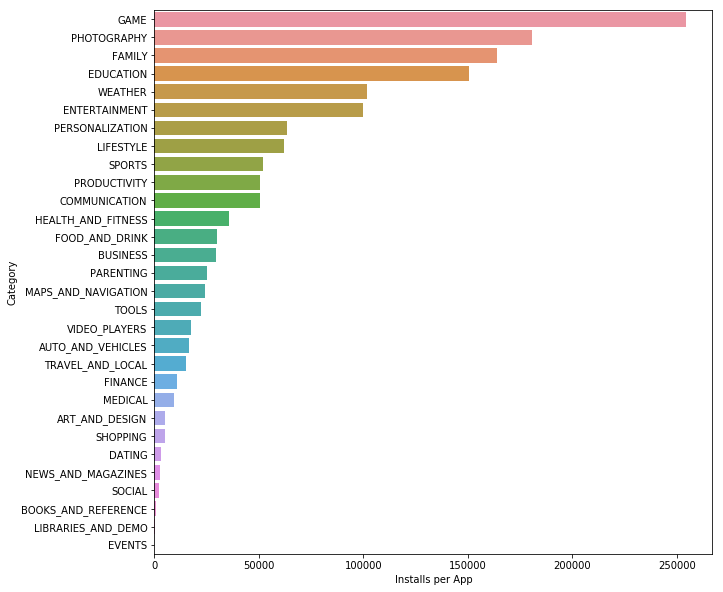

In [0]:
app_install["Installs per App"] = app_install["Clean Installs"]/app_install["App"]
app_install.sort_values(by="Installs per App",inplace = True,ascending = False)
plt.figure(figsize=(10,10))
sns.barplot(app_install["Installs per App"],app_install.index)

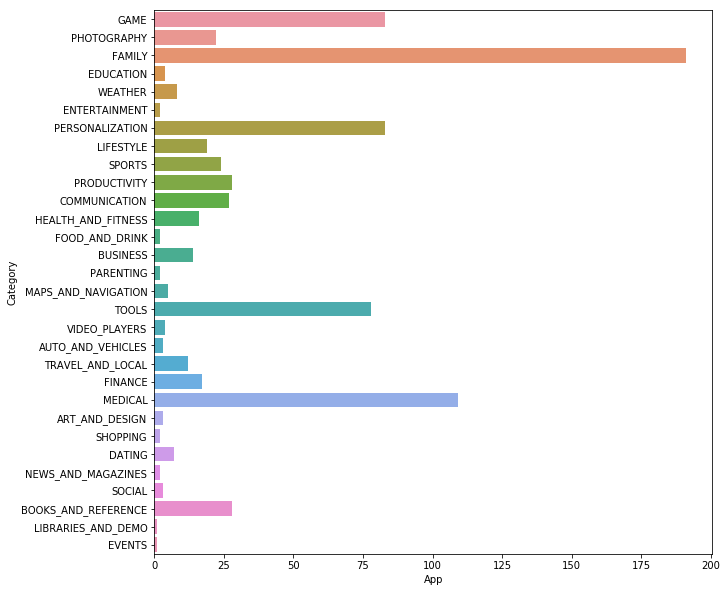

In [0]:
plt.figure(figsize=(10,10))
common_developed_app = app_install.sort_values(by="App",ascending = False).head(10)
sns.barplot(app_install["App"],app_install.index)

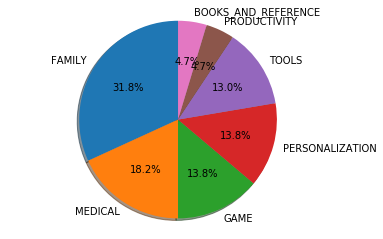

In [0]:
common_developed_app = app_install.sort_values(by="App",ascending = False).head(7)
fig1, ax1 = plt.subplots()
ax1.pie(common_developed_app["App"], labels=common_developed_app.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

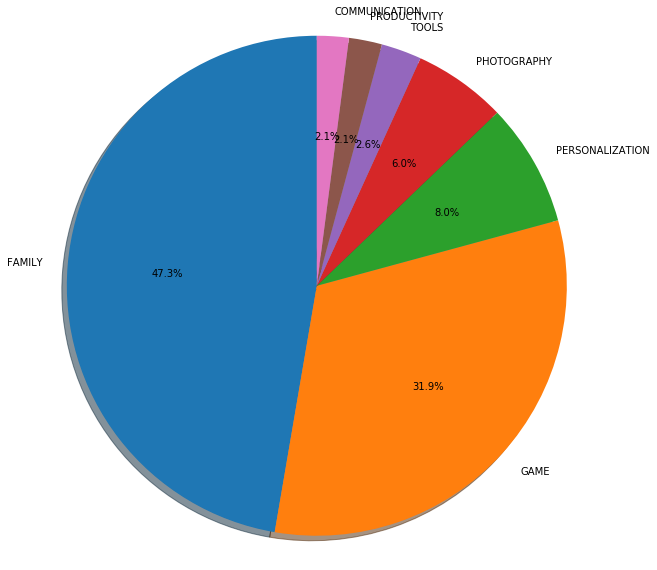

In [0]:
common_installed_app = app_install.sort_values(by="Clean Installs",ascending = False).head(7)
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(common_installed_app["Clean Installs"], labels=common_installed_app.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

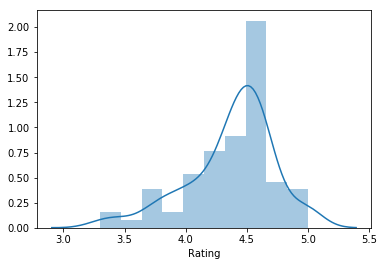

In [0]:
sns.distplot(paid_app[(paid_app["Category"]=="GAME")&(~paid_app["Rating"].isnull())]["Rating"])

In [0]:
paid_app.sample(5)

App         Category  ...  Clean Size   Revenue
2401            Diabetes & Diet Tracker          MEDICAL  ...        19.0    9990.0
4779                 X Back - Icon Pack  PERSONALIZATION  ...        26.0    9900.0
854                 Toca Life: Hospital        EDUCATION  ...        24.0  399000.0
8800             Dr. Panda Restaurant 2           FAMILY  ...        67.0  299000.0
9934  I'm Rich/Eu sou Rico/أنا غني/我很有錢        LIFESTYLE  ...        40.0       0.0

[5 rows x 16 columns]

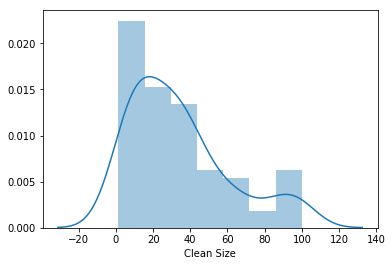

In [0]:
sns.distplot(paid_app[(paid_app["Category"]=="GAME")&(~paid_app["Clean Size"].isnull())]["Clean Size"])

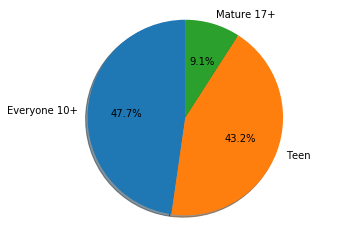

In [0]:
content_rating = paid_app[(paid_app["Category"]=="FAMILY")]["Content Rating"].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(content_rating.values, labels=content_rating.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

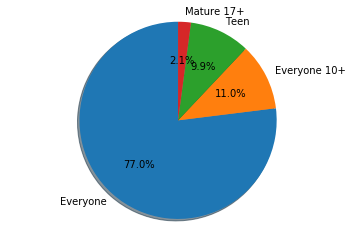

In [0]:
content_rating = paid_app[paid_app["Category"]=="FAMILY"]["Content Rating"].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(content_rating.values, labels=content_rating.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

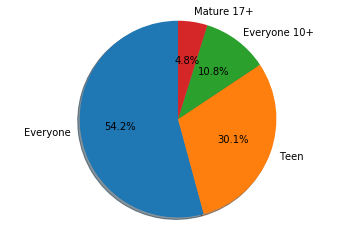

In [0]:
content_rating = paid_app[paid_app["Category"]=="GAME"]["Content Rating"].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(content_rating.values, labels=content_rating.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

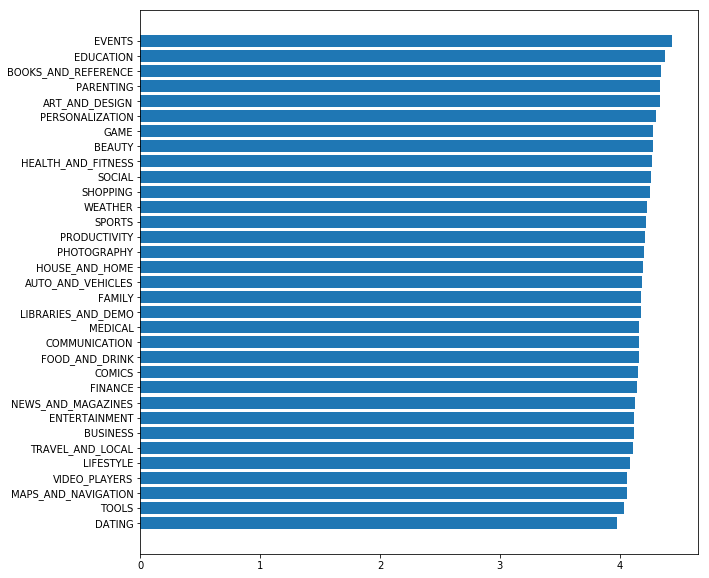

In [0]:
fa_mean_rating = free_app.groupby("Category").mean()["Rating"].sort_values()
fa_mean_rating = fa_mean_rating[~fa_mean_rating.isnull()]
plt.figure(figsize=(10,10))
plt.barh(fa_mean_rating.index, fa_mean_rating.values)
plt.show()

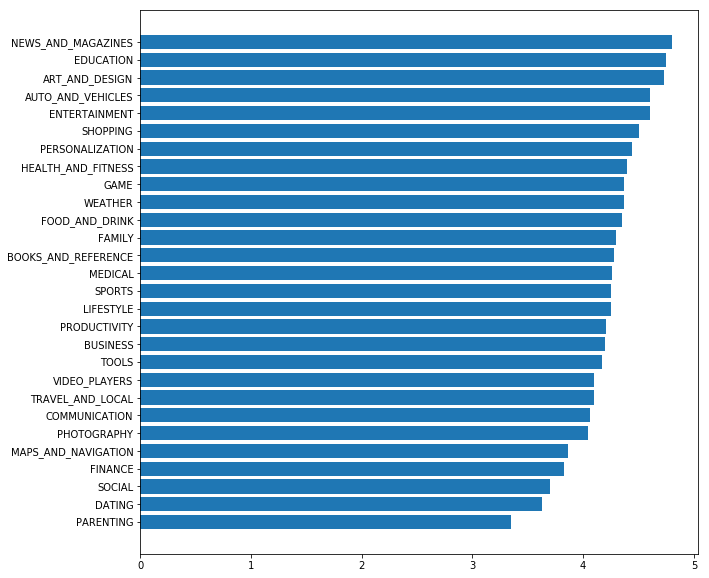

In [0]:
pa_mean_install = paid_app.groupby("Category").mean()["Rating"].sort_values()
pa_mean_install = pa_mean_install[~pa_mean_install.isnull()]
plt.figure(figsize=(10,10))
plt.barh(pa_mean_install.index, pa_mean_install.values)
plt.show()

In [0]:
google

App  ...    Revenue
0         Photo Editor & Candy Camera & Grid & ScrapBook  ...      200.0
1                                    Coloring book moana  ...    10000.0
2      U Launcher Lite – FREE Live Cool Themes, Hide ...  ...   100000.0
3                                  Sketch - Draw & Paint  ...  1000000.0
4                  Pixel Draw - Number Art Coloring Book  ...     2000.0
5                             Paper flowers instructions  ...     1000.0
6                Smoke Effect Photo Maker - Smoke Editor  ...     1000.0
7                                       Infinite Painter  ...    20000.0
8                                   Garden Coloring Book  ...    20000.0
9                          Kids Paint Free - Drawing Fun  ...      200.0
10                               Text on Photo - Fonteee  ...    20000.0
11               Name Art Photo Editor - Focus n Filters  ...    20000.0
12                        Tattoo Name On My Photo Editor  ...   200000.0
13                                 Mandala Coloring Book  ...     2000.0
14       3D Color Pixel by Number - Sandbox Art Coloring  ...     2000.0
15                       Learn To Draw Kawaii Characters  ...      100.0
16          Photo Designer - Write your name with shapes  ...    10000.0
17                              350 Diy Room Decor Ideas  ...      200.0
18                         FlipaClip - Cartoon animation  ...   100000.0
19                                          ibis Paint X  ...   200000.0
20                           Logo Maker - Small Business  ...     2000.0
21             Boys Photo Editor - Six Pack & Men's Suit  ...     2000.0
22               Superheroes Wallpapers | 4K Backgrounds  ...    10000.0
23                                Mcqueen Coloring pages  ...     2000.0
24                           HD Mickey Minnie Wallpapers  ...     1000.0
25                            Harley Quinn wallpapers HD  ...      200.0
26                         Colorfit - Drawing & Coloring  ...    10000.0
27                                 Animated Photo Editor  ...     2000.0
28                                 Pencil Sketch Drawing  ...      200.0
29                       Easy Realistic Drawing Tutorial  ...     2000.0
...                                                  ...  ...        ...
10811                                        FR Plus 1.6  ...        NaN
10812                                      Fr Agnel Pune  ...        NaN
10813                                     DICT.fr Mobile  ...        NaN
10814                               FR: My Secret Pets!   ...        NaN
10815                          Golden Dictionary (FR-AR)  ...        NaN
10816                                 FieldBi FR Offline  ...        NaN
10817                               HTC Sense Input - FR  ...        NaN
10818                               Gold Quote - Gold.fr  ...        NaN
10819                                          Fanfic-FR  ...        NaN
10820                                    Fr. Daoud Lamei  ...        NaN
10821                                            Poop FR  ...        NaN
10822                                          PLMGSS FR  ...        NaN
10823                                       List iptv FR  ...        NaN
10824                                          Cardio-FR  ...        NaN
10825                                 Naruto & Boruto FR  ...        NaN
10826          Frim: get new friends on local chat rooms  ...        NaN
10827                                 Fr Agnel Ambarnath  ...        NaN
10828                            Manga-FR - Anime Vostfr  ...        NaN
10829                     Bulgarian French Dictionary Fr  ...        NaN
10830                                  News Minecraft.fr  ...        NaN
10831                           payermonstationnement.fr  ...        NaN
10832                                           FR Tides  ...        NaN
10833                                        Chemin (fr)  ...        NaN
10834                                 

In [0]:
google.to_csv('cleaned_data_Hang.csv')